# Regresión lineal sobre precios de casas utilizando *TensorFlow* y normalización de variables de entrenamiento

In [2]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

### Cargamos los datos del proyecto

En el proyecto se concluyó que la variable *OverallQual* generaba un menor de la función de costo. Por lo tanto, en esta tarea se utilizará dicha variable para efectuar la regresión lineal simple. 

In [3]:
data = np.load("proyecto_training_data.npy")
# Cantidad de datos y regresoras
OBS, NVAR = data.shape
(OBS, NVAR)

# Dividir el conjunto de datos
TRAINOBS = int(OBS*0.8)

# Conjunto de datos de entrenamiento
Ytrain = data[:TRAINOBS, 0]
Xtrain = data[:TRAINOBS, 1]
print("Entrenamiento: ", Ytrain.shape, Xtrain.shape)

# Conjunto de datos de validación y pruebas
Ytest = data[TRAINOBS:, 0]
Xtest = data[TRAINOBS:, 1]
print("Prueba: ", Ytest.shape, Xtest.shape)

Entrenamiento:  (1168,) (1168,)
Prueba:  (292,) (292,)


## Gráfica de los datos

Vamos a graficar los datos nuevamente, para observar el modelo final obtenido con TensorFlow

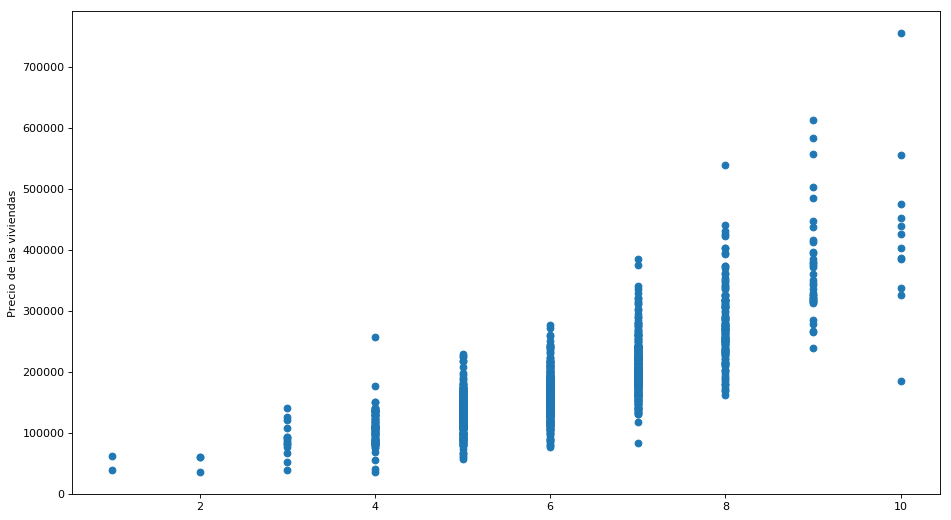

In [4]:
fig = plt.figure(figsize=(14, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xtrain, Ytrain)
#plt.title("Gráfica de modelos en función del número de iteración.")
plt.ylabel("Precio de las viviendas");

## Normalización de las variables para el proceso de entrenamiento

In [5]:
def normalizar(x):
    # Obtener la media
    x_mean = np.mean(x)
    # Obtener la desviación
    x_sd = np.std(x)
    # Normalizar la variable
    y = (x - x_mean) / x_sd
    
    return (y, x_mean, x_sd)

In [6]:
# Normalizando valores de X e Y
Ytrain, ytrain_mean, ytrain_sd = normalizar(Ytrain)
Xtrain, xtrain_mean, xtrain_sd = normalizar(Xtrain)

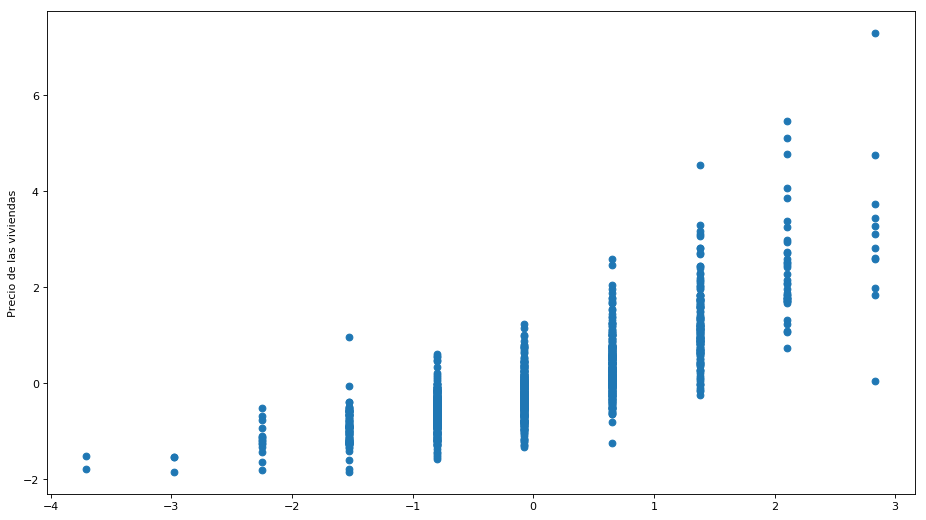

In [7]:
# Graficamos nuevamente X e Y
fig = plt.figure(figsize=(14, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xtrain, Ytrain)
#plt.title("Gráfica de modelos en función del número de iteración.")
plt.ylabel("Precio de las viviendas");

## Construcción del modelo en TensorFlow

En esta sección construiremos el modelo a través de un grafo en TensorFlow. Para esto, construiremos la función de hipótesis, la función de costo y el optimizador (a través de gradiente en descenso de TensorFlow). Finalmente, inicializaremos los parámetros entrenables del modelo. 

In [42]:
# Crear un grafo específico
g = tf.Graph()
# Definimos tensores y operaciones en g
with g.as_default():
    # Creando los placeholders
    X = tf.placeholder(tf.float32, name="X")
    Y = tf.placeholder(tf.float32, name="Y")

    # Declaramos las variables entrenables de TensorFlow
    # para la pendiente y el intersecto (bias) de la regresión lineal
    # Se inicializan las variables igual que en el proyecto, pendiente = 1, intersecto = 0
    W = tf.Variable(tf.constant(1.), name = "W") 
    b = tf.Variable(tf.constant(0.), name = "b") 

    # Hiperparámetros del modelo
    lr = tf.placeholder(tf.float32, name="lr")
    
    # Función de pronóstico o hipótesis
    Yhat = tf.add(tf.multiply(X, W), b, name="Yhat") 

    # Función de costo
    cost = tf.reduce_sum(tf.pow(Yhat-Y, 2)) / (2 * TRAINOBS) 

    # Gradient Descent Optimizer 
    optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost) 

    # Global Variables Initializer 
    init = tf.global_variables_initializer() 

    # Summary para el TensorBoard
    testSummary = tf.summary.scalar(name='Funcion_de_costo', tensor = cost)
    

## Proceso de entrenamiento 

Ahora se realizará el entrenamiento del modelo utilizando un objeto *TensorFlow.Session* para llevar a cabo la evaluación de los nodos correspondientes.

In [43]:
def entrenarModeloLineal(x, y, training_epochs, learning_rate, imprimirCada):
    # Starting the Tensorflow Session 
    with tf.Session(graph = g) as sess: 

        # Crear el writer
        writer = tf.summary.FileWriter('./testGraphg/lr='+str(learning_rate), sess.graph)
        # Initializing the Variables 
        sess.run(init) 

        # Iterating through all the epochs 
        for epoch in range(training_epochs): 

            # Feeding each data point into the optimizer using Feed Dictionary 
            #for (_x, _y) in zip(x, y): 
            sess.run(optimizer, feed_dict = {X : x, Y : y, lr : learning_rate}) 

            # Displaying the result after every 50 epochs 
            if (epoch + 1) % imprimirCada == 0: 
                # Calculating the cost a every epoch 
                c = sess.run(cost, feed_dict = {X : Xtrain, Y : Ytrain}) 
                print("Epoch", (epoch + 1), ": cost =", c, "W =", sess.run(W), "b =", sess.run(b)) 

            # Ejecutar el summary 
            summary = sess.run(testSummary, feed_dict = {X : x, Y : y})
            # Agregarlo al tablero
            writer.add_summary(summary, epoch)


        # Cerrar el writer
        writer.close()
        
        # Storing necessary values to be used outside the Session 
        training_cost = sess.run(cost, feed_dict ={X: x, Y: y}) 
        weight = sess.run(W) 
        bias = sess.run(b) 
        
    return (weight, bias, training_cost)


## Hipótesis respecto a los diferentes valores del hiperparámetro *learning rate*

Los valores de *learning rate* a probar son los siguientes: 

    10, 1, 0.1, 0.01, 0.001, 0.0001
    
**Hipótesis**: 
* De forma preliminar, se podría pensar que los valores muy grandes (10 y 1) podrían alejarnos del mínimo en la función de costo. Posiblemente los saltos en el gradiente en descenso serían muy grandes, y por lo tanto, el costo probablemente aumentaría en este caso.

* Respecto a los valores muy pequeños (0.001 y 0.0001), es posible que con estos valores los pasos sean demasiado pequeños en la función de costo, y por lo tanto, podría ser que requieran muchas más iteraciones para converger al mínimo.

* Respecto a los valores del centro (0.1, 0.01) podrían ser valores ideales para la convergencia del mínimo en la función de costo. 

Para probar la hipótesis acerca de los valores se utilizará la **misma cantidad de *epochs*** de entrenamiento para solamente observar el efecto del *learning rate* en el proceso de entrenamiento.

In [44]:
# Función para graficar modelo resultante
def graficarModelo(weight, bias, costo):
    # Calcular los valores ajustados
    predictions = weight * Xtrain + bias 
    print("Costo =", costo, "Pendiente =", weight, "Intercepto =", bias, '\n') 
    # Grafica del modelo
    fig = plt.figure(figsize=(14, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.scatter(Xtrain, Ytrain, label = 'Valores observados')
    plt.ylabel("Precio de las viviendas");
    plt.plot(Xtrain, predictions, 'r', label ='Valores ajustados')  
    plt.legend() 
    plt.show() 

## Entrenamiento con learning_rate = 1

In [45]:
weight, bias, costo = entrenarModeloLineal(Xtrain, Ytrain, training_epochs=100, learning_rate=1, imprimirCada=10)

Epoch 10 : cost = 0.18478991 W = 0.79399 b = 1.1641532e-08
Epoch 20 : cost = 0.18478991 W = 0.79399 b = 1.1641532e-08
Epoch 30 : cost = 0.18478991 W = 0.79399 b = 1.1641532e-08
Epoch 40 : cost = 0.18478991 W = 0.79399 b = 1.1641532e-08
Epoch 50 : cost = 0.18478991 W = 0.79399 b = 1.1641532e-08
Epoch 60 : cost = 0.18478991 W = 0.79399 b = 1.1641532e-08
Epoch 70 : cost = 0.18478991 W = 0.79399 b = 1.1641532e-08
Epoch 80 : cost = 0.18478991 W = 0.79399 b = 1.1641532e-08
Epoch 90 : cost = 0.18478991 W = 0.79399 b = 1.1641532e-08
Epoch 100 : cost = 0.18478991 W = 0.79399 b = 1.1641532e-08


Costo = 0.18478991 Pendiente = 0.79399 Intercepto = 1.1641532e-08 



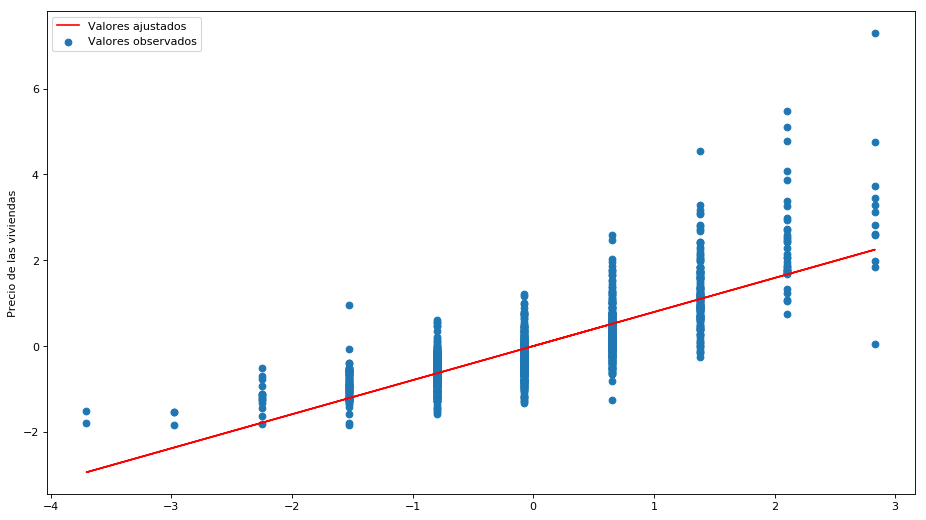

In [46]:
graficarModelo(weight, bias, costo)

## Entrenamiento con learning_rate = 10

In [47]:
weight, bias, costo = entrenarModeloLineal(Xtrain, Ytrain, training_epochs=100, learning_rate=10, imprimirCada=10)

Epoch 10 : cost = 2.5798518e+17 W = 718310850.0 b = -33.26775
Epoch 20 : cost = inf W = 2.5045957e+18 b = -671894000000.0
Epoch 30 : cost = inf W = 8.733009e+27 b = -1.6571531e+21
Epoch 40 : cost = inf W = 3.0450156e+37 b = -7.5291985e+30
Epoch 50 : cost = nan W = nan b = nan
Epoch 60 : cost = nan W = nan b = nan
Epoch 70 : cost = nan W = nan b = nan
Epoch 80 : cost = nan W = nan b = nan
Epoch 90 : cost = nan W = nan b = nan
Epoch 100 : cost = nan W = nan b = nan


Costo = nan Pendiente = nan Intercepto = nan 



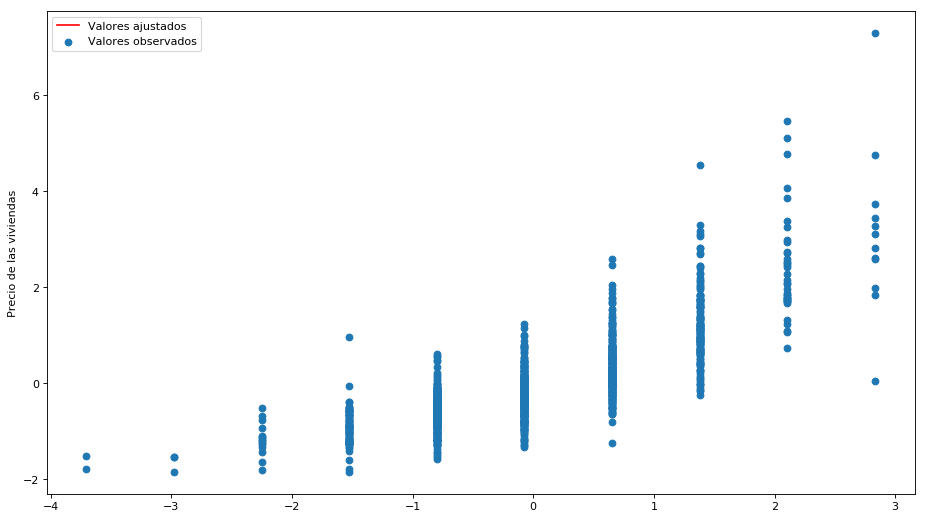

In [48]:
graficarModelo(weight, bias, costo)

## Entrenamiento con learning_rate = 0.1

In [49]:
weight, bias, costo = entrenarModeloLineal(Xtrain, Ytrain, training_epochs=100, learning_rate=0.1, imprimirCada=10)

Epoch 10 : cost = 0.18736978 W = 0.8658213 b = 5.2619726e-09
Epoch 20 : cost = 0.18510354 W = 0.81903607 b = 1.0011718e-08
Epoch 30 : cost = 0.18482804 W = 0.80272305 b = 9.918586e-09
Epoch 40 : cost = 0.18479455 W = 0.79703504 b = 1.6158447e-08
Epoch 50 : cost = 0.18479046 W = 0.79505175 b = 1.8533319e-08
Epoch 60 : cost = 0.18478997 W = 0.79436016 b = 2.4540348e-08
Epoch 70 : cost = 0.18478991 W = 0.79411906 b = 2.6542692e-08
Epoch 80 : cost = 0.1847899 W = 0.794035 b = 2.7846545e-08
Epoch 90 : cost = 0.1847899 W = 0.79400575 b = 2.6077032e-08
Epoch 100 : cost = 0.1847899 W = 0.79399556 b = 2.081506e-08


Costo = 0.1847899 Pendiente = 0.79399556 Intercepto = 2.081506e-08 



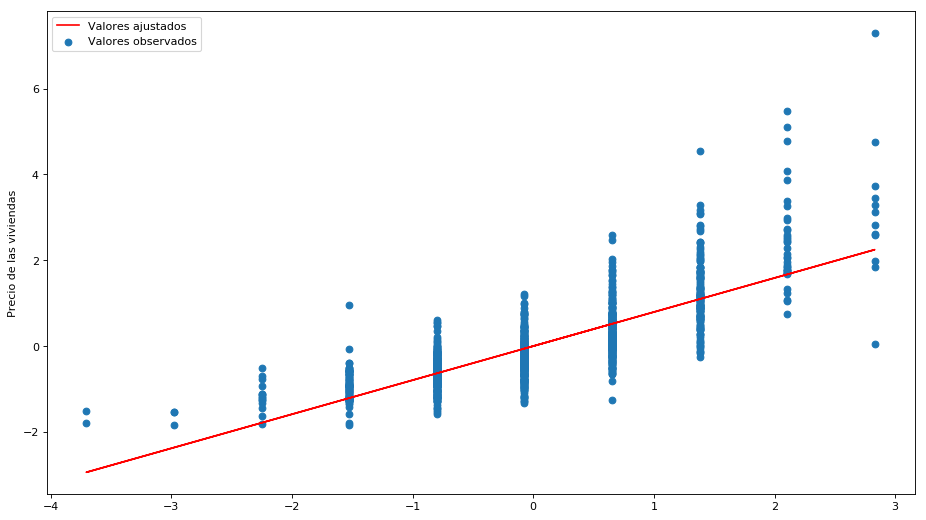

In [50]:
graficarModelo(weight, bias, costo)

## Entrenamiento con learning_rate = 0.01

In [51]:
weight, bias, costo = entrenarModeloLineal(Xtrain, Ytrain, training_epochs=100, learning_rate=0.01, imprimirCada=10)

Epoch 10 : cost = 0.20214592 W = 0.9803017 b = 9.220093e-10
Epoch 20 : cost = 0.19898547 W = 0.9624869 b = 2.1932647e-09
Epoch 30 : cost = 0.19640055 W = 0.9463756 b = 3.222376e-09
Epoch 40 : cost = 0.19428639 W = 0.93180484 b = 3.8044528e-09
Epoch 50 : cost = 0.19255714 W = 0.9186274 b = 4.363246e-09
Epoch 60 : cost = 0.19114277 W = 0.90670973 b = 4.6473e-09
Epoch 70 : cost = 0.18998595 W = 0.8959317 b = 4.945323e-09
Epoch 80 : cost = 0.18903978 W = 0.8861842 b = 5.9930603e-09
Epoch 90 : cost = 0.18826587 W = 0.87736875 b = 6.0768794e-09
Epoch 100 : cost = 0.18763292 W = 0.86939627 b = 6.7101786e-09


Costo = 0.18763292 Pendiente = 0.86939627 Intercepto = 6.7101786e-09 



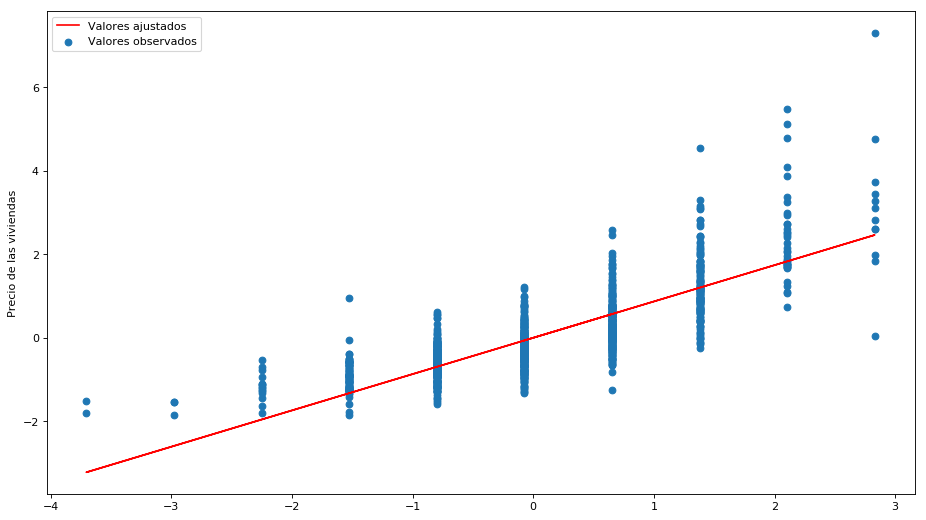

In [52]:
graficarModelo(weight, bias, costo)

## Entrenamiento con learning_rate = 0.001

In [53]:
weight, bias, costo = entrenarModeloLineal(Xtrain, Ytrain, training_epochs=100, learning_rate=0.001, imprimirCada=10)

Epoch 10 : cost = 0.20558955 W = 0.9979492 b = 8.381904e-12
Epoch 20 : cost = 0.20517747 W = 0.99591875 b = 6.8452216e-11
Epoch 30 : cost = 0.20477359 W = 0.9939085 b = 1.3643876e-10
Epoch 40 : cost = 0.20437773 W = 0.9919183 b = 2.5192276e-10
Epoch 50 : cost = 0.20398965 W = 0.9899479 b = 3.5762787e-10
Epoch 60 : cost = 0.20360927 W = 0.9879972 b = 4.6147036e-10
Epoch 70 : cost = 0.20323643 W = 0.9860658 b = 5.3504495e-10
Epoch 80 : cost = 0.20287101 W = 0.9841537 b = 6.295742e-10
Epoch 90 : cost = 0.20251279 W = 0.98226064 b = 7.2782874e-10
Epoch 100 : cost = 0.20216171 W = 0.98038644 b = 7.622877e-10


Costo = 0.20216171 Pendiente = 0.98038644 Intercepto = 7.622877e-10 



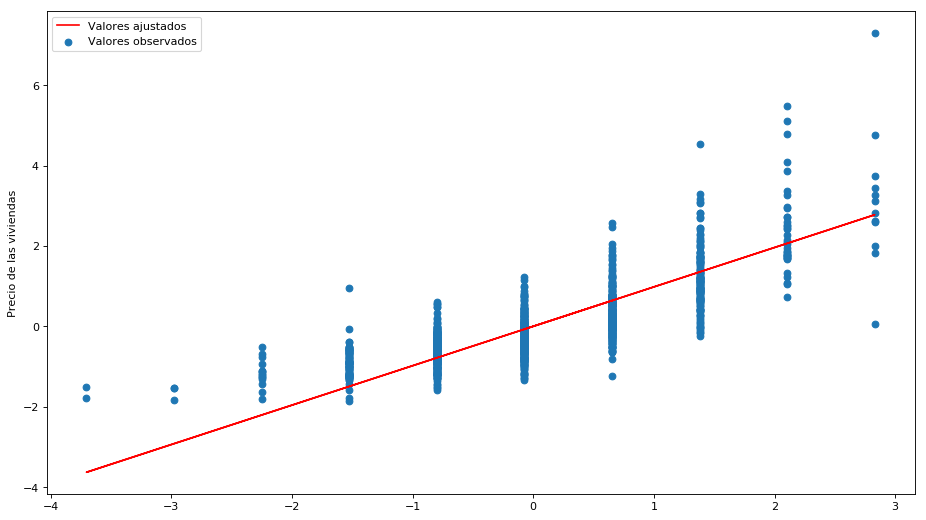

In [54]:
graficarModelo(weight, bias, costo)

## Entrenamiento con learning_rate = 0.0001

In [55]:
weight, bias, costo = entrenarModeloLineal(Xtrain, Ytrain, training_epochs=100, learning_rate=0.0001, imprimirCada=10)

Epoch 10 : cost = 0.20596755 W = 0.9997941 b = 8.288771e-12
Epoch 20 : cost = 0.20592524 W = 0.9995885 b = 1.6437844e-11
Epoch 30 : cost = 0.205883 W = 0.99938285 b = 2.3236501e-11
Epoch 40 : cost = 0.20584087 W = 0.99917763 b = 2.7846546e-11
Epoch 50 : cost = 0.20579882 W = 0.9989726 b = 4.08385e-11
Epoch 60 : cost = 0.2057568 W = 0.99876755 b = 4.7963116e-11
Epoch 70 : cost = 0.2057149 W = 0.998563 b = 5.5134296e-11
Epoch 80 : cost = 0.20567314 W = 0.99835855 b = 6.365589e-11
Epoch 90 : cost = 0.20563138 W = 0.9981541 b = 7.5390555e-11
Epoch 100 : cost = 0.20558976 W = 0.9979502 b = 8.540228e-11


Costo = 0.20558976 Pendiente = 0.9979502 Intercepto = 8.540228e-11 



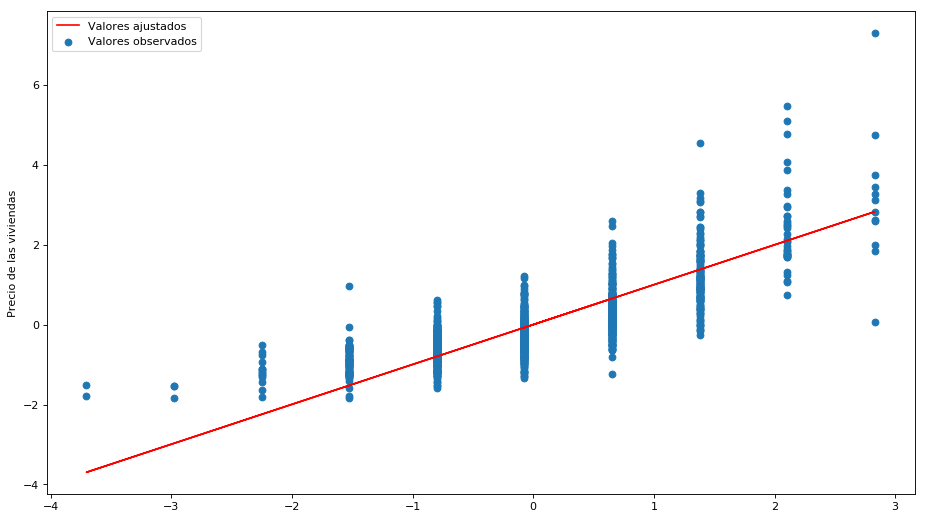

In [56]:
graficarModelo(weight, bias, costo)

## Gráficas del modelo y de la función de costo en *TensorBoard*

<img src="grafoFinal.png">

### Resultados con normalización de variables

<img src="curvasConNormalizacion.png">

## Conclusiones

Como se observa en las gráficas de *TensorBoard*, conforme el *learning rate* es más pequeño, la función de costo disminuye más lentamente en cada epoch. Con el *learning rate* de 10, el error en el primer epoch es muy alto y no aparece en la gráfica. Como se ve en la sección del código del entrenamiento, los valores de la función de costo se hicieron muy grandes, por lo que se descarta su utilización para propósitos de entrenamiento. 

Finalmente, el valor de *learning rate* que generaron un menor valor de costo fueron 1 y 0.1. 